In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.optimizers import *
from lib.functions import *
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

### $F$ - a more complex function

$$ M = 8, N = 12, F : \R^M \to \R^N$$

$$ F(x) = \begin{bmatrix}
    \sin(x_1) + \cos(2x_1) \\
    \cos(-2x_2 + 1) \\
    2 \exp(x_3) \\
    \exp(\sin(||x||_2)) \\
    \left(\exp\left(1 + \sum_{i=1}^{M} x_i\right)\right)^2 \\
    \cos(\exp(\sin^2(x_5))) \\
    \left(\sin\left(\sqrt{|\sum_{i=1}^M x_i|} - 1\right)\right)^2 \\
    \sqrt{\sin(\prod_{i=1}^M x_i) + 2} \\
    \left|\prod_{i=1}^M x_i\right| + 1 \\
    \sin(x_1) + \cos(x_2) + \exp(x_3) + x_4^2 + |x_5| + \sqrt{|x_6|} + \sin^2(x_7) + \sqrt{|\cos(\exp(\sin(x_8)))|} \\
    \sin(||x||_2) + \cos(||x||_2) - \exp\left(\sum_{i=1}^M x_i\right) \\
    ||x||_2^2
\end{bmatrix}$$

In [3]:
M = 8
sin = Function(F=np.sin, DF=np.cos, M=1, N=1)
cos = Function(F=np.cos, DF=lambda x: -np.sin(x), M=1, N=1)
exp = Function(F=np.exp, DF=np.exp, M=1, N=1)
square = Function(F=lambda x: x**2, DF=lambda x: 2 * x, M=1, N=1)
abs = Function(F=np.abs, DF=lambda x: np.sign(x), M=1, N=1)
sqrt = Function(F=lambda x: np.sqrt(np.abs(x)), DF=lambda x: 0.5 / np.sqrt(np.abs(x)) * np.sign(x), M=1, N=1)
norm = Function(F=np.linalg.norm, DF=lambda x: x / np.linalg.norm(x), M=M, N=1)
sum_ = Function(F=np.sum, DF=lambda _: np.ones(M), M=M, N=1)
mul_ = Function(F=lambda x: np.array(np.prod(x)), DF=lambda x: np.prod(x) / x, M=M, N=1)
proj = lambda k: Function(F=lambda x: x[k], DF=lambda _: np.eye(M)[k], M=M, N=1)
constM = lambda c: Function(F=lambda _: np.array(c), DF=lambda _: np.zeros(M), M=M, N=1)
const1 = lambda c: Function(F=lambda _: np.array(c), DF=lambda _: np.zeros(1), M=1, N=1)
mul_const = lambda c: Function(F=lambda x: c * x, DF=lambda _: np.array(c), M=1, N=1)

F1 = compose(proj(0), sin + compose(mul_const(2), cos))
F2 = compose(proj(1), mul_const(-2) + const1(1), cos)
F3 = compose(proj(2), 2 * exp)
F4 = compose(norm, sin, exp)
F5 = compose(sum_ + constM(1), exp, square)
F6 = compose(proj(5), sin, square, exp, cos)
F7 = compose(sum_, sqrt - const1(1), sin, square)
F8 = compose(mul_, sin + const1(2), sqrt)
F9 = compose(mul_, abs + const1(1))
F10 = (
    compose(proj(0), sin) + compose(proj(1), cos) + compose(proj(2), exp) + compose(proj(3), square) + compose(proj(4), abs) 
    + compose(proj(5), sqrt) + compose(proj(6), sin, square) + compose(proj(7), sin, exp, cos, sqrt)
)
F11 = compose(norm, sin + cos) - compose(sum_, exp)
F12 = compose(norm, square)
F = stack(F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12)

## Hyperparameters

In [10]:
np.random.seed(42)
p0 = np.random.randn(M)
max_iter = 10000
p0

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473])

## Gradient descent method

In [11]:
p, err = gradient_descent(F, p0, 1e-10, max_iter)
print(f"{p=}\n{err=}")

p=array([ 7.68952714e-04, -6.34200635e-01,  1.51736886e-01,  1.02707221e+00,
       -7.30080621e-01, -7.30066668e-01,  1.08326202e+00,  2.71501570e-01])
err=19.590567931950634


## Gauss-Newton method

In [18]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter, alpha=1e-3, step_type="solve")
print(f"{p=}\n{err=}")

Singular matrix encountered in 107-th iteration. Returning current point.
p=array([ 0.60818589, -0.15357403,  0.54068914,  1.84621584, -0.0564157 ,
       -0.33186968,  1.43746048,  0.46333348])
err=44714.468389903705


In [17]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter, alpha=1e-3, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([ 1.56524214e+00, -2.85391613e-01, -9.35231147e+00,  4.21366425e+00,
        1.00613118e+01, -7.36890646e-01, -5.46561431e+00, -1.41967642e-07])
err=241.8848553676758


## Levenberg-Marquardt method

#### 1. Constant $\lambda_k$ sequence

In [25]:
lambda_param = 1e-1
optimizer = LevenbergMarquardt(
    R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
)

In [26]:
p, err = optimizer.optimize(p0, max_iter, step_type="solve")
print(f"{p=}\n{err=}")

p=array([-0.52930211, -0.28449688, -1.70472337,  0.63891491,  1.17416181,
       -0.67912275,  0.55640406,  0.03812203])
err=6.659665706790292


In [27]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([-0.51465716, -0.2695337 , -1.52393084,  0.62655059,  1.06897708,
       -0.66591659, -0.14776259, -0.10727145])
err=5.715461302574509


In [ ]:
# p, err = optimizer.optimize(p0, max_iter, step_type="ridge")
# print(f"{p=}\n{err=}")

#### 2. Sequence $\lambda_k$ decrasing when error is decreasing, and increasing otherwise

In [29]:
optimizer = LevenbergMarquardt(
    R=F,
    lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=1., lambda_change=1.1),
)

In [30]:
p, err = optimizer.optimize(p0, max_iter, step_type="solve")
print(f"{p=}\n{err=}")

p=array([-4.86529195e-01, -2.43506597e-01, -5.85107953e-01, -7.72034728e-02,
       -1.01032838e-05,  2.45269522e-04, -7.72580795e-02,  3.17336345e-01])
err=3.7170934394964372


In [31]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([-4.77692046e-01, -2.35725549e-01, -5.70345868e-01, -7.22994013e-02,
       -8.53141256e-05,  5.91540009e-04, -7.23976209e-02,  2.33452451e-01])
err=3.720840198215124


In [ ]:
# p, err = optimizer.optimize(p0, max_iter, step_type="ridge")
# print(f"{p=}\n{err=}")

### Helper functions

In [32]:
_infty = 1e32
_zero = 1e-32

def remove_nans_infs_and_zeros(arr):
    arr = np.array(arr)
    arr[np.isnan(arr)] = _infty
    arr[np.isinf(arr)] = _infty
    arr[arr == 0] = _zero
    return arr

## Test parameters

In [34]:
lambda_params = [10**i for i in range(-10, 3)]
p0s = [p0]
max_iter = 1000

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, lambda_param in enumerate(lambda_params):
    print(f"lambda_param: {lambda_param} ({i + 1}/{len(lambda_params)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda_param, lambda_change=2)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=F, p0=p0, alpha=lambda_param, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=F, p0=p0, alpha=lambda_param, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

lambda_param: 1e-10 (1/13)
Levenberg-Marquardt: 52-th iteration failed. Returning current point.
lambda_param: 1e-09 (2/13)
lambda_param: 1e-08 (3/13)
lambda_param: 1e-07 (4/13)


C:\Users\matip\AppData\Local\Temp\ipykernel_36160\4155888824.py:10: RuntimeWarning: invalid value encountered in divide
  mul_ = Function(F=lambda x: np.array(np.prod(x)), DF=lambda x: np.prod(x) / x, M=M, N=1)


Levenberg-Marquardt: 199-th iteration failed. Returning current point.


c:\Users\matip\Documents\UW\ml-numerki\project\lib\optimizers.py:37: RuntimeWarning: overflow encountered in matmul
  p = p - alpha * DR(p).T @ R(p)


lambda_param: 1e-06 (5/13)


c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:43: RuntimeWarning: invalid value encountered in sin
  return self.F(x)
c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:30: RuntimeWarning: invalid value encountered in cos
  DF = lambda x: DF_old(x).reshape(1, M)


lambda_param: 1e-05 (6/13)
lambda_param: 0.0001 (7/13)
Levenberg-Marquardt: 88-th iteration failed. Returning current point.
lambda_param: 0.001 (8/13)
lambda_param: 0.01 (9/13)
lambda_param: 0.1 (10/13)
lambda_param: 1 (11/13)
lambda_param: 10 (12/13)
Least squares failed in 2-th iteration. Returning current point.


C:\Users\matip\AppData\Local\Temp\ipykernel_36160\4155888824.py:5: RuntimeWarning: overflow encountered in scalar power
  square = Function(F=lambda x: x**2, DF=lambda x: 2 * x, M=1, N=1)
c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:43: RuntimeWarning: invalid value encountered in cos
  return self.F(x)
C:\Users\matip\AppData\Local\Temp\ipykernel_36160\4155888824.py:3: RuntimeWarning: invalid value encountered in sin
  cos = Function(F=np.cos, DF=lambda x: -np.sin(x), M=1, N=1)


lambda_param: 100 (13/13)
Least squares failed in 2-th iteration. Returning current point.


In [35]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_std_lm_const = np.std(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)
errors_std_lm_const = remove_nans_infs_and_zeros(errors_std_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_std_lm_mod = np.std(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)
errors_std_lm_mod = remove_nans_infs_and_zeros(errors_std_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_std = np.std(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)
errors_gn_std = remove_nans_infs_and_zeros(errors_gn_std)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_std = np.std(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)
errors_gd_std = remove_nans_infs_and_zeros(errors_gd_std)

c:\Python310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


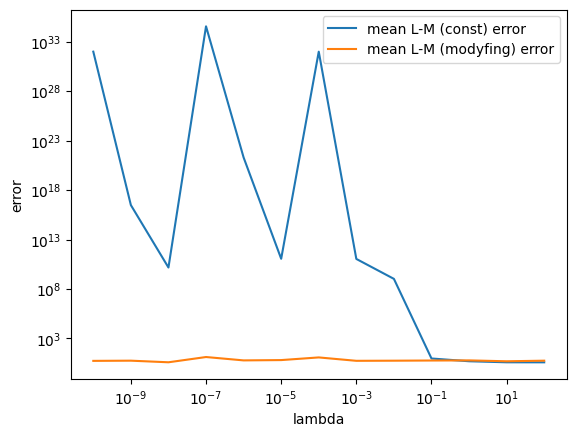

In [36]:
plt.loglog(lambda_params, errors_mean_lm_const, label="mean L-M (const) error")
# plt.loglog(lambda_params, errors_std_lm_const, label="L-M (const) error std", linestyle="--")

plt.loglog(lambda_params, errors_mean_lm_mod, label="mean L-M (modyfing) error")
# plt.loglog(lambda_params, errors_std_lm_mod, label="L-M (modyfing) error std", linestyle="--")

plt.legend()
plt.xlabel("lambda")
plt.ylabel("error")
plt.show()

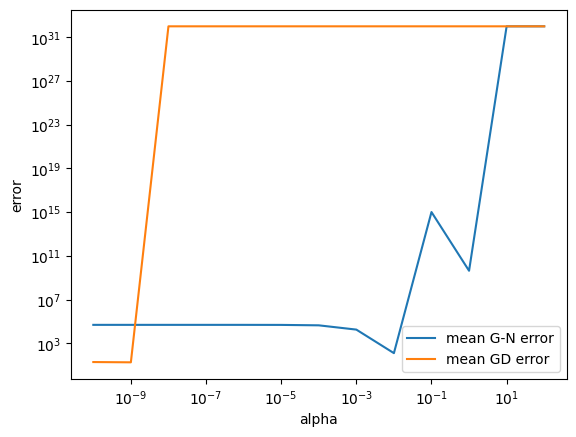

In [37]:
plt.loglog(lambda_params, errors_gn_mean, label="mean G-N error")
# plt.loglog(lambda_params, errors_gn_std, label="G-N error std", linestyle="--")

plt.loglog(lambda_params, errors_gd_mean, label="mean GD error")
# plt.loglog(lambda_params, errors_gd_std, label="GD error std", linestyle="--")

plt.legend()
plt.xlabel("alpha")
plt.ylabel("error")
plt.show()

## Test number of iterations

In [45]:
max_iters = [10**i for i in range(0, 5)]
p0s = [p0]
alpha_gd = 1e-10
alpha_gn = 1e-2
lambda0 = 1
lambda_change = 2

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, max_iter in enumerate(max_iters):
    print(f"max_iter: {max_iter} ({i + 1}/{len(max_iters)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=F, p0=p0, alpha=alpha_gn, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=F, p0=p0, alpha=alpha_gd, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

max_iter: 1 (1/5)
max_iter: 10 (2/5)
max_iter: 100 (3/5)
max_iter: 1000 (4/5)
max_iter: 10000 (5/5)


c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:43: RuntimeWarning: overflow encountered in exp
  return self.F(x)
c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:30: RuntimeWarning: overflow encountered in exp
  DF = lambda x: DF_old(x).reshape(1, M)


Least squares failed in 6640-th iteration. Returning current point.


In [46]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_std_lm_const = np.std(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)
errors_std_lm_const = remove_nans_infs_and_zeros(errors_std_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_std_lm_mod = np.std(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)
errors_std_lm_mod = remove_nans_infs_and_zeros(errors_std_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_std = np.std(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)
errors_gn_std = remove_nans_infs_and_zeros(errors_gn_std)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_std = np.std(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)
errors_gd_std = remove_nans_infs_and_zeros(errors_gd_std)

c:\Python310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


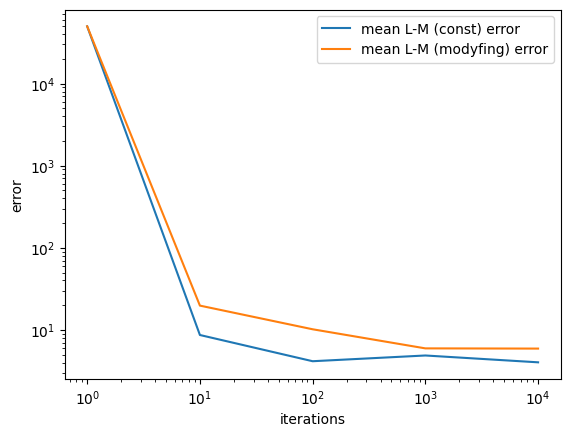

In [47]:
plt.loglog(max_iters, errors_mean_lm_const, label="mean L-M (const) error")
# plt.loglog(lambda_params, errors_std_lm_const, label="L-M (const) error std", linestyle="--")

plt.loglog(max_iters, errors_mean_lm_mod, label="mean L-M (modyfing) error")
# plt.loglog(lambda_params, errors_std_lm_mod, label="L-M (modyfing) error std", linestyle="--")

plt.legend()
plt.xlabel("iterations")
plt.ylabel("error")
plt.show()

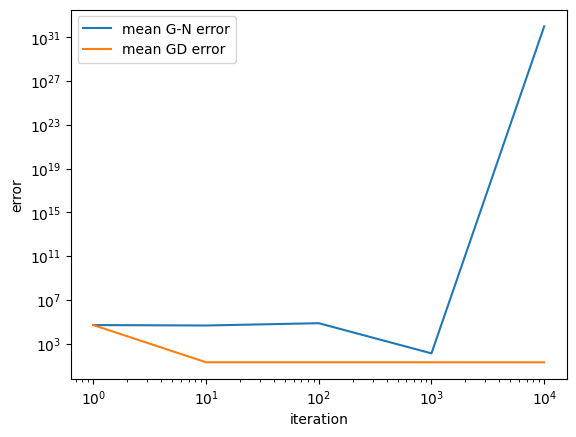

In [48]:
plt.loglog(max_iters, errors_gn_mean, label="mean G-N error")
# plt.loglog(lambda_params, errors_gn_std, label="G-N error std", linestyle="--")

plt.loglog(max_iters, errors_gd_mean, label="mean GD error")
# plt.loglog(lambda_params, errors_gd_std, label="GD error std", linestyle="--")

plt.legend()
plt.xlabel("iteration")
plt.ylabel("error")
plt.show()